<a href="https://colab.research.google.com/github/alfredoh90/Capstone3/blob/main/modelingV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
seed = 180

In [ ]:
# Importing Keras
from keras.models import Sequential                          # Neural network model as a sequence of layers.
from keras.layers import Conv2D                              # Convolutional layer
from keras.layers import MaxPooling2D                        # Max pooling layer
from keras.layers import Flatten                             # Layer used to flatten 2D arrays for fully-connected layers.
from keras.layers import Dense                               # This layer adds fully-connected layers to the neural network.
from keras.layers import Dropout                             # This serves to prevent overfitting by dropping out a random set of activations.
from keras.layers import BatchNormalization                  # This is used to normalize the activations of the neurons.
from keras.layers import Activation                          # Layer for activation functions
from keras.callbacks import EarlyStopping, ModelCheckpoint   # Classes used to save weights and stop training when improvements reach a limit
from keras.models import load_model                          # This helps us to load trained models
# Preprocessing layers
from keras.layers import Rescaling                           # This layer rescales pixel values

# Importing TensorFlow
import tensorflow as tf

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if True :#gpus:
    try:
        #for gpu in gpus:
            #tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        strategy = tf.distribute.OneDeviceStrategy(device ="/gpu:0")
        print('\nGPU Found! Using GPU...')
    except RuntimeError as e:
        print(e)
#else:
    #strategy = tf.distribute.get_strategy() #remove to try to use the GPU
    #print('Number of replicas:', strategy.num_replicas_in_sync)


GPU Found! Using GPU...


In [ ]:
# Creating a Dataset for the Training data
train = tf.keras.utils.image_dataset_from_directory(
    "drive/MyDrive/Capstone3/data/train",  # Directory where the Training images are located
    labels = 'inferred', # Classes will be inferred according to the structure of the directory
    label_mode = 'categorical',
    class_names = ['pos', 'neg'], #extensions of the folders holding the classes
    batch_size = 16,    # Number of processed samples before updating the model's weights
    image_size = (400, 400), # Defining a fixed dimension for all images
    shuffle = True,  # Shuffling data
    seed = seed,  # Random seed for shuffling and transformations
    validation_split = 0, # We don't need to create a validation set from the training set
    crop_to_aspect_ratio = True # Resize images without aspect ratio distortion
)

Found 12019 files belonging to 2 classes.


In [ ]:
# Creating a Dataset for the Test data
testing = tf.keras.utils.image_dataset_from_directory(
    "drive/MyDrive/Capstone3/data/test",  # Directory where the Training images are located
    labels = 'inferred', # Classes will be inferred according to the structure of the directory
    label_mode = 'categorical',
    class_names = ['pos', 'neg'], #extensions of the folders holding the classes
    batch_size = 16,    # Number of processed samples before updating the model's weights
    image_size = (400, 400), # Defining a fixed dimension for all images
    shuffle = True,  # Shuffling data
    seed = seed,  # Random seed for shuffling and transformations
    validation_split = 0, # We don't need to create a validation set from the training set
    crop_to_aspect_ratio = True # Resize images without aspect ratio distortion
)

Found 3629 files belonging to 2 classes.


In [ ]:
print('\nTraining Dataset:', train)
print('\nTraining Dataset:', testing)


Training Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 400, 400, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

Training Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 400, 400, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


We are getting the results of how the data is going to be reviewed:
<ul>
    <li>Data is going to be returned in batches</li>
    <li><b>TensorSpec(shape=(None, 400, 400, 3), dtype=tf.uint8, name=None)</b> represents the features. None represents the batch size, which is None here because it can vary depending on how many samples we have in the last batch; 400, 400 represents the height and width of the images; 3 is the number of channels in the images, indicating they are RGB images. Last, dtype=tf.unit8 tells us that the data type of the image pixels is an unsigned integer of 8 bits.</li>
    <li><b>TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)</b> represents the labels in our dataset. Here, None refers to the batch size; 2 refers to the number of labels in the dataset; whilst dtype=tf.float32 is also a 32-bit floating point. </li>
</ul>

The next step for preprocessing is ensuring that the pixel values of our images are within a 0 to 1 range. First lest confirm the minimum and maximum pixel value for the training dataset:

In [ ]:
# Checking minimum and maximum pixel values in the training and testing dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in train:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)

    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())

print('\nMinimum pixel value in the Training dataset', min_value)
print('\nMaximum pixel value in the Training dataset', max_value)

min_value = float('inf')
max_value = -float('inf')
for img, label in testing:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)

    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())

print('\nMinimum pixel value in the Testing dataset', min_value)
print('\nMaximum pixel value in the Testing dataset', max_value)

In [ ]:
scaler = Rescaling(1./255) # Defining scaler values between 0 to 1

In [ ]:
# Rescaling datasets
train = train.map(lambda x, y: (scaler(x), y))
testing = testing.map(lambda x, y: (scaler(x), y))

In [ ]:
# Checking minimum and maximum pixel values in the training dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in train:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)

    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())

print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)

After scaling, it looks like the pixels are withing the 0 and 1 range and we can now continue with building the model. To build the Convolutional Neural Network with Keras, we are going to use the <i>Sequential</i> class. This class allows us to build a linear stack of layers, which is essential for the creation of neural networks.

In [ ]:
# Creating data augmentation pipeline
augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(
        factor = (-.25, .3),
        fill_mode = 'reflect',
        interpolation = 'bilinear',
        seed = seed),


        tf.keras.layers.RandomBrightness(
        factor = (-.45, .45),
        value_range = (0.0, 1.0),
        seed = seed),

        tf.keras.layers.RandomContrast(
        factor = (.5),
        seed = seed)
    ]
)

In [ ]:
# Defining an Early Stopping and Model Checkpoints
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              patience = 5, mode = 'max',
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('best_model.keras',
                            monitor = 'val_accuracy',
                            save_best_only = True)

In [ ]:
# Initiating model on GPU
with strategy.scope():
    model = Sequential()

    model.add(augmentation) # Adding data augmentation pipeline to the model

    # Feature Learning Layers
    model.add(Conv2D(32,                  # Number of filters/Kernels
                     (3,3),               # Size of kernels (3x3 matrix)
                     strides = 1,         # Step size for sliding the kernel across the input (1 pixel at a time).
                     padding = 'same',    # 'Same' ensures that the output feature map has the same dimensions as the input by padding zeros around the input.
                    input_shape = (400,400,3) # Input image shape
                    ))
    model.add(Activation('relu'))# Activation function
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (5,5), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (5,5), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(512, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    # Flattening tensors
    model.add(Flatten())

    # Fully-Connected Layers
    model.add(Dense(2048))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(2, activation = 'sigmoid')) # Binary classification layer


    # Compiling model
    model.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001), # 1e-4
              loss = 'binary_crossentropy', # Ideal for multiclass tasks
              metrics = ['accuracy']) # Evaluation metric
    #compile the model
    try:
      history = model.fit(
        train, epochs = 70,
        validation_data = testing)
    except Exception as e:
      print("An error occurred:", e)

Epoch 1/70
752/752 ━━━━━━━━━━━━━━━━━━━━ 199s 254ms/step - accuracy: 0.6653 - loss: 2.3487 - val_accuracy: 0.7884 - val_loss: 0.9207
Epoch 2/70
752/752 ━━━━━━━━━━━━━━━━━━━━ 191s 253ms/step - accuracy: 0.8162 - loss: 0.4717 - val_accuracy: 0.8380 - val_loss: 1.4569
Epoch 3/70
752/752 ━━━━━━━━━━━━━━━━━━━━ 190s 253ms/step - accuracy: 0.8428 - loss: 0.4327 - val_accuracy: 0.8393 - val_loss: 1.4782
Epoch 4/70
752/752 ━━━━━━━━━━━━━━━━━━━━ 190s 253ms/step - accuracy: 0.8487 - loss: 0.4136 - val_accuracy: 0.8184 - val_loss: 1.6180
Epoch 5/70
752/752 ━━━━━━━━━━━━━━━━━━━━ 190s 253ms/step - accuracy: 0.8555 - loss: 0.4033 - val_accuracy: 0.8071 - val_loss: 3.2350
Epoch 6/70
752/752 ━━━━━━━━━━━━━━━━━━━━ 190s 253ms/step - accuracy: 0.8633 - loss: 0.3954 - val_accuracy: 0.8148 - val_loss: 2.8935
Epoch 7/70
752/752 ━━━━━━━━━━━━━━━━━━━━ 190s 253ms/step - accuracy: 0.8654 - loss: 0.3756 - val_accuracy: 0.8121 - val_loss: 0.9599
Epoch 8/70
752/752 ━━━━━━━━━━━━━━━━━━━━ 190s 253ms/step - accuracy: 0.8657 -

In [ ]:
model.save('drive/MyDrive/Capstone3/safety_gear_detect_V4.keras')

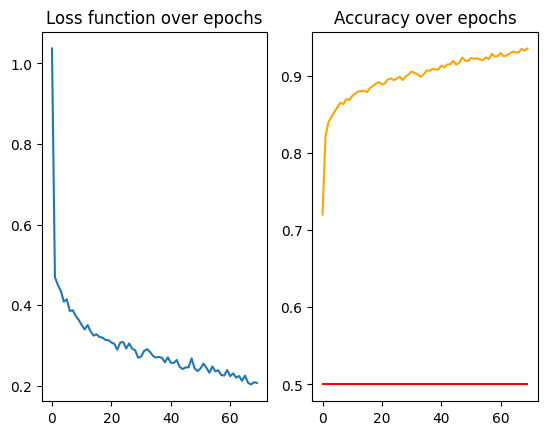

In [ ]:
# Creating subplot
fig, (ax1, ax2) = plt.subplots(1,2)

# Loss over epochs
ax1.plot(range(len(history.history['loss'])), history.history['loss'])
ax1.set_title('Loss function over epochs')
ax2.plot(range(len(history.history['loss'])), history.history['accuracy'], color = 'orange')
ax2.plot(range(len(history.history['loss'])), np.ones(70)*0.5, color = 'red')
ax2.set_title('Accuracy over epochs')
fig.show()

In [ ]:
model.summary() #printing model summary

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 400, 400, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 400, 400, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 400, 400, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 400, 400, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 200, 200, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 200, 200, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 200, 200, 64)        │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 200, 200, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 200, 200, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 100, 100, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 100, 100, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 100, 100, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 50, 50, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 50, 50, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 50, 50, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 358,688,198 (1.34 GB)

 Trainable params: 179,343,106 (684.14 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 179,343,108 (684.14 MB)

The summary displays the output shapes for each layer and the number of parameters. We can see the output shape for the first layer is (None, 400,400,3) where 400 is both the width and height, while 3 represents the RGB color. In the last dense layer, however, the output shape is (None, 2), where 2 represents the 2 classes for classification.

Next, we will calculate the predictions from the model using .predict and calculate the loss and accuracy from the test images:

In [ ]:
preds = model.predict(testing)  # Running model on the test dataset
val_loss, val_acc = model.evaluate(testing) # Obtaining Loss and Accuracy on the val dataset

print('\nValidation Loss: ', val_loss)
print('\nValidation Accuracy: ', np.round(val_acc * 100), '%')

227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9007 - loss: 0.3525

Validation Loss:  0.358897864818573

Validation Accuracy:  90.0 %
